# SPAM or HAM

## Implementing proper Text Mining

This notebook builds upon the previous one by:

1. Improving the text mining processing using NLTK:
    - Explores the usage of TF and TF-IDF for textual analysis
2. Implementing a set of visualization methods
3. Implementing a simple feature selection method

In [18]:
import math
import nltk
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 72
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/joao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/joao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/joao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/joao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/joao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Helper Functions
 

In [12]:
def np_log_fit(x, y):
    a, b = np.polyfit(np.log(x), y, 1)
    return a, b


def np_exp_fit(x, y):
    a, b = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
    return a, np.exp(b)


def plot_vocab(vocab):
    words = [word for word,_ in vocab]
    probs = [prob for _,prob in vocab]
    x_pos = np.arange(len(words)) 

    #slope, intercept = np.polyfit(x_pos, probs, 1)
    #trendline = intercept + (slope * x_pos)

    a, b = np_exp_fit(x_pos, probs)
    trendline_exp = b*np.exp(a*x_pos)

    #plt.plot(x_pos, trendline, color='red', linestyle='--')
    plt.plot(x_pos, trendline_exp, color='green', linestyle='--')
    plt.bar(x_pos, probs,align='center')
    plt.xticks(x_pos, words) 
    plt.ylabel('Probs')
    plt.xticks(rotation=45, ha='right')
    plt.show()


def _nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:          
        return None


def _nltk_pos_lemmatizer(lemmatizer, token, tag):
    if tag is None:
        return lemmatizer.lemmatize(token)
    else:        
        return lemmatizer.lemmatize(token, tag)


def text_pre_processing(txt, m=2):
    if txt is not None:
        lemmatizer = WordNetLemmatizer()
        stop_words = set(nltk.corpus.stopwords.words('english'))

        tokens = nltk.word_tokenize(txt)
        tokens = [w for w in tokens if w.isalpha()]
        tokens = nltk.pos_tag(tokens)
        tokens = [(t[0], _nltk_pos_tagger(t[1])) for t in tokens]
        tokens = [_nltk_pos_lemmatizer(lemmatizer, w, t).lower() for w,t in tokens]
        tokens = [w for w in tokens if len(w) > m]
        tokens = [w for w in tokens if w not in stop_words]
    else:
        tokens = []
    return tokens

In [13]:
df = pl.read_csv('datasets/spam.csv')
df

Target,SMS
str,str
"""ham""","""Go until jurong point, crazy..…"
"""ham""","""Ok lar... Joking wif u oni..."""
"""spam""","""Free entry in 2 a wkly comp to…"
"""ham""","""U dun say so early hor... U c …"
"""ham""","""Nah I don't think he goes to u…"
…,…
"""spam""","""This is the 2nd time we have t…"
"""ham""","""Will �_ b going to esplanade f…"
"""ham""","""Pity, * was in mood for that. …"


In [14]:
dataset = df.rows()
dataset = [(text, label) for (label, text) in dataset]
idx = int(len(dataset)*.8)
dataset_train = dataset[0: idx]
dataset_test = dataset[idx:]

In [15]:
dataset_spam = [text for text, label in dataset if label == 'spam']
dataset_ham = [text for text, label in dataset if label == 'ham']

## Term Frequency

Term frequency is the measurement of how frequently a term occurs within a document.
The easiest calculation is simply counting the number of times a word appears.
However, there are ways to modify that value based on the document length or the frequency of the most frequently used word in the document.

Bellow we will explore the usage of TF-IDF as a ranking method.

In [16]:
def get_frequencies(dataset, n=2):
    samples = [text_pre_processing(sample) for sample in dataset]
    samples = [token for sample in samples for token in sample]
    vocab =  list(set(samples))
    freqs = Counter(samples)

    return vocab, freqs

## Data visualization

there are two traditional visualizations for textual data:
1. Bar plots (for frequency and ranking)
2. WordClouds

### Word clouds 
Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text.
The larger the word in the visual the more common the word was in the document(s).

### HAM

Counter({'get': 569, 'come': 318, 'call': 289, 'know': 256, 'good': 244, 'like': 240, 'time': 223, 'want': 211, 'love': 211, 'day': 210, 'say': 208, 'tell': 188, 'send': 181, 'think': 177, 'need': 173, 'take': 171, 'one': 167, 'see': 163, 'lor': 162, 'home': 160, 'sorry': 155, 'make': 152, 'still': 149, 'today': 135, 'later': 135, 'back': 129, 'work': 129, 'dont': 127, 'well': 126, 'ask': 122, 'pls': 115, 'give': 115, 'night': 112, 'much': 111, 'leave': 109, 'thing': 109, 'hope': 107, 'wat': 106, 'happy': 106, 'great': 105, 'miss': 105, 'dear': 102, 'way': 101, 'meet': 99, 'hey': 99, 'wait': 93, 'right': 91, 'already': 90, 'really': 85, 'yeah': 85, 'pick': 85, 'feel': 84, 'amp': 84, 'phone': 83, 'wan': 81, 'let': 80, 'tomorrow': 80, 'text': 77, 'would': 77, 'yes': 76, 'please': 76, 'morning': 75, 'sleep': 75, 'friend': 74, 'try': 74, 'lol': 74, 'message': 74, 'keep': 74, 'life': 74, 'buy': 71, 'sure': 70, 'anything': 70, 'care': 70, 'week': 69, 'also': 68, 'number': 68, 'even': 66, 'ba

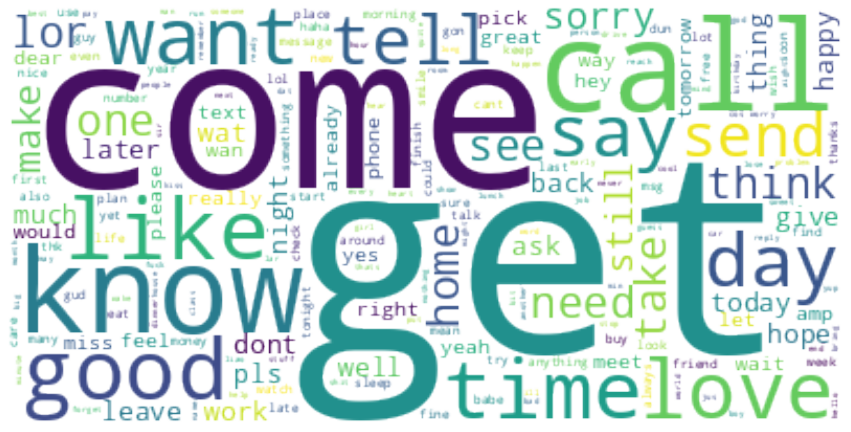

In [19]:
vocab, freqs_dict = get_frequencies(dataset_ham)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

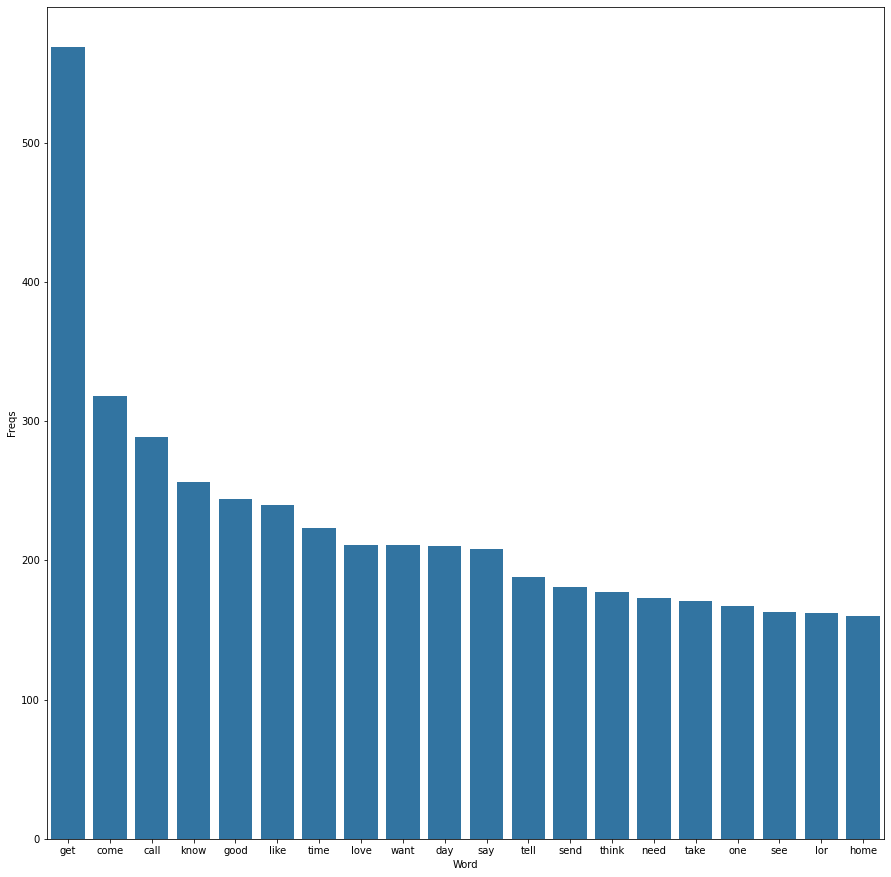

In [20]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

### SPAM

Counter({'call': 359, 'free': 218, 'txt': 156, 'text': 136, 'mobile': 130, 'claim': 115, 'stop': 113, 'reply': 111, 'win': 110, 'prize': 94, 'get': 91, 'send': 80, 'new': 72, 'service': 67, 'nokia': 65, 'award': 65, 'tone': 63, 'week': 62, 'cash': 62, 'urgent': 62, 'contact': 61, 'phone': 57, 'please': 54, 'customer': 51, 'per': 46, 'chat': 45, 'message': 40, 'guaranteed': 40, 'draw': 40, 'try': 39, 'number': 39, 'offer': 39, 'receive': 37, 'line': 37, 'show': 35, 'landline': 34, 'min': 34, 'camera': 33, 'msg': 33, 'voucher': 33, 'every': 33, 'holiday': 32, 'rate': 31, 'want': 31, 'live': 30, 'box': 30, 'apply': 29, 'code': 29, 'chance': 29, 'video': 29, 'day': 29, 'ringtone': 28, 'network': 27, 'late': 27, 'entry': 26, 'select': 26, 'orange': 26, 'collection': 26, 'word': 25, 'cost': 25, 'end': 25, 'mob': 25, 'know': 25, 'date': 25, 'charge': 24, 'find': 24, 'collect': 24, 'weekly': 24, 'back': 23, 'valid': 23, 'pound': 23, 'today': 22, 'attempt': 22, 'await': 22, 'delivery': 21, 'bon

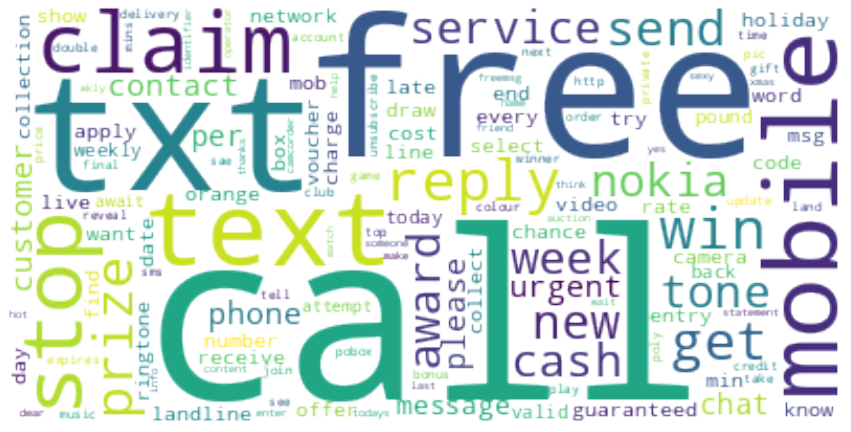

In [21]:
vocab, freqs_dict = get_frequencies(dataset_spam)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

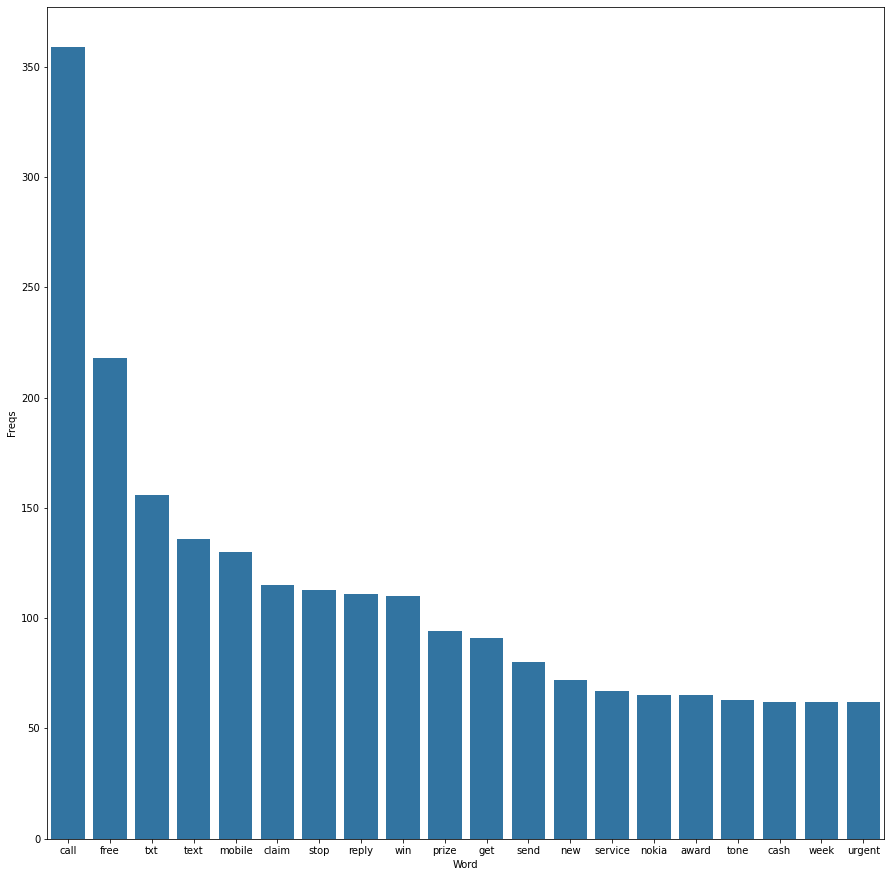

In [22]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

### SPAM + HAM

Counter({'get': 660, 'call': 648, 'come': 324, 'know': 281, 'free': 277, 'send': 261, 'good': 257, 'like': 253, 'want': 242, 'time': 242, 'day': 239, 'love': 221, 'text': 213, 'say': 208, 'tell': 206, 'think': 192, 'take': 190, 'need': 184, 'see': 181, 'one': 177, 'txt': 169, 'make': 166, 'home': 162, 'lor': 162, 'reply': 159, 'sorry': 158, 'today': 157, 'still': 156, 'stop': 156, 'back': 152, 'mobile': 145, 'phone': 140, 'dont': 138, 'new': 138, 'later': 135, 'work': 132, 'week': 131, 'well': 131, 'please': 130, 'win': 127, 'ask': 127, 'pls': 125, 'give': 123, 'night': 119, 'dear': 118, 'great': 116, 'claim': 115, 'message': 114, 'miss': 114, 'try': 113, 'leave': 112, 'much': 112, 'thing': 112, 'hope': 111, 'wait': 109, 'wat': 107, 'happy': 107, 'number': 107, 'meet': 106, 'hey': 104, 'way': 102, 'prize': 94, 'right': 94, 'msg': 93, 'wan': 93, 'already': 91, 'yes': 91, 'pick': 91, 'friend': 90, 'tomorrow': 90, 'late': 88, 'find': 87, 'feel': 86, 'really': 86, 'yeah': 86, 'let': 85, 'a

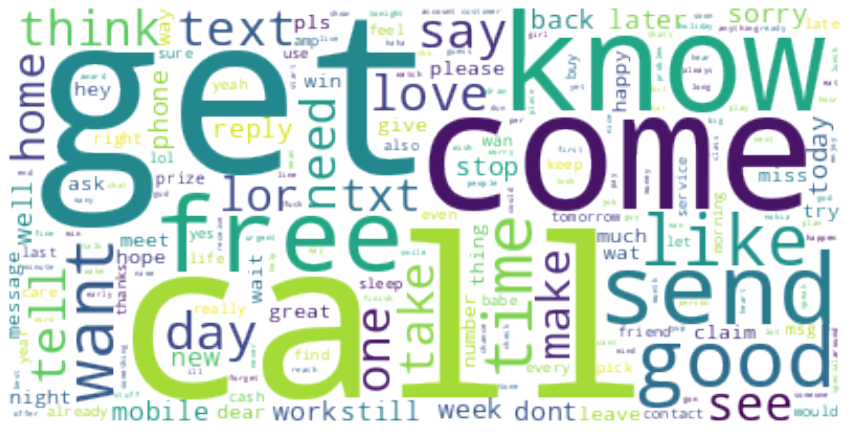

In [23]:
dataset_no_label = [text for text, _ in dataset]
vocab, freqs_dict = get_frequencies(dataset_no_label)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

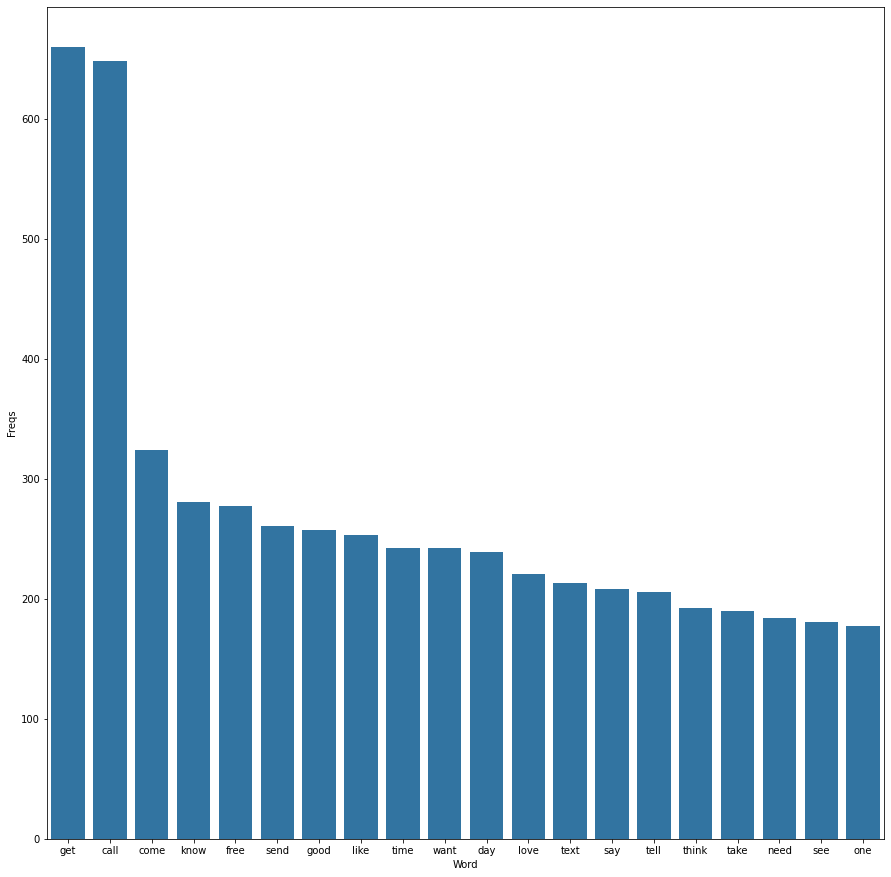

In [24]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

## TF-IDF

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

TF-IDF for a word in a document is calculated by multiplying two different metrics:

- The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.
- The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.

$$ tf\textnormal{-}idf(t) = tf(t) \times idf(t) $$
$$ tf(t)  = \log(1+freq(t)) $$
$$ idf(t) = \log\left(\frac{N}{count(t \in D)+1}\right) $$

There are several other ranking schemes, please check [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

In [25]:
def get_tfidf(dataset, n=2):
    samples = [text_pre_processing(sample) for sample in dataset]
    samples_flat = [token for sample in samples for token in sample]
    vocab =  list(set(samples_flat))
    tf = Counter(samples_flat)
    for k in vocab:
        tf[k] = math.log((tf[k]/len(dataset))+1)
    
    idf = {}
    for k in vocab:
        number_documents_word = 0
        for d in samples:
            if k in d:
                number_documents_word += 1
        idf[k] = math.log(len(dataset)/(number_documents_word+1))

    tfidf = {}
    for k in vocab:
        tfidf[k] = tf[k] * idf[k]

    return vocab, tfidf

{'professional': 0.0014347393813635228, 'gary': 0.003926967253974447, 'prod': 0.0014347393813635228, 'remb': 0.0014347393813635228, 'tel': 0.01602798304009153, 'maths': 0.0014347393813635228, 'wings': 0.0014347393813635228, 'toshiba': 0.0027223911591436312, 'night': 0.08330134739597038, 'libertines': 0.0014347393813635228, 'film': 0.01405566258892347, 'charge': 0.03399254400273044, 'transfer': 0.008281491824392034, 'smart': 0.0061767910119699225, 'recount': 0.0014347393813635228, 'lotta': 0.0027223911591436312, 'depends': 0.0061767910119699225, 'hoo': 0.0014347393813635228, 'dust': 0.0014347393813635228, 'asthma': 0.0014347393813635228, 'attract': 0.0014347393813635228, 'bong': 0.0014347393813635228, 'fujitsu': 0.0027223911591436312, 'count': 0.003926967253974447, 'games': 0.0061767910119699225, 'vco': 0.0014347393813635228, 'unsold': 0.003926967253974447, 'ring': 0.02179327394698456, 'benefit': 0.0027223911591436312, 'yrs': 0.003926967253974447, 'formal': 0.0014347393813635228, 'yowif

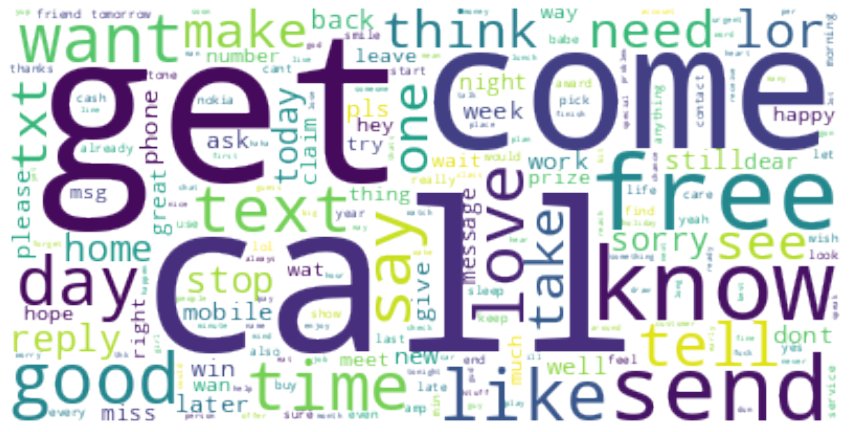

In [26]:
dataset_no_label = [text for text, _ in dataset]
vocab, tfidf_dict = get_tfidf(dataset_no_label)

print(f'{tfidf_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(tfidf_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

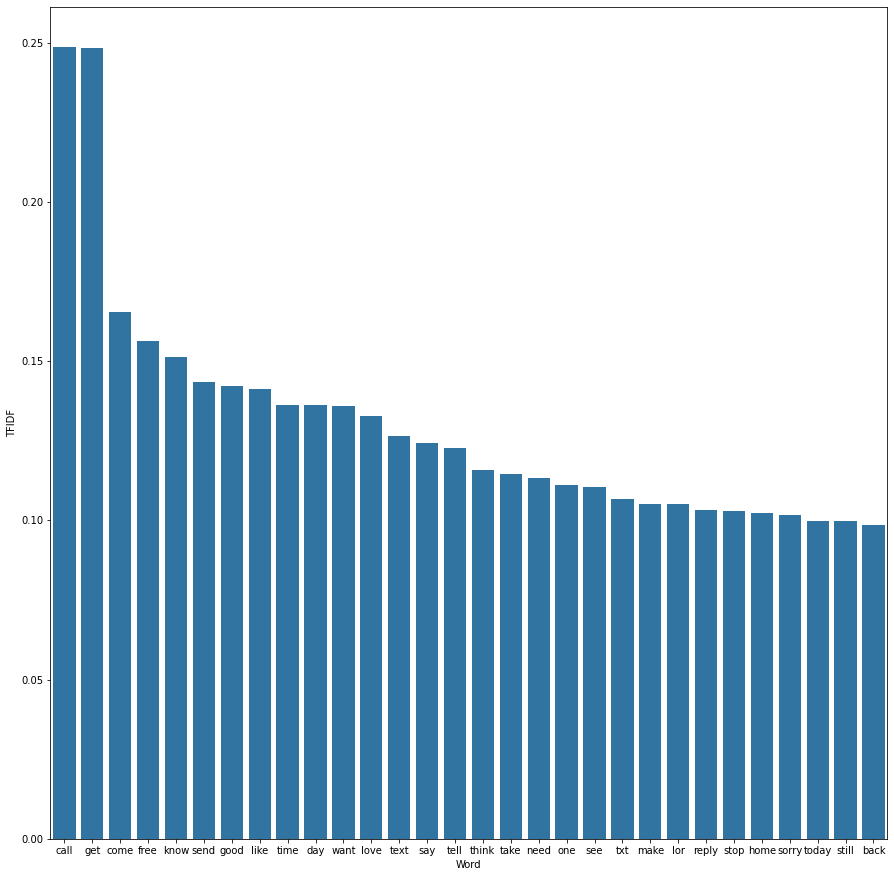

In [27]:
tfidf = [tfidf_dict[w] for w in vocab]

zipped_lists = zip(vocab, tfidf)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, tfidf = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:30], 'TFIDF': tfidf[0:30]})
sns.barplot(x='Word', y='TFIDF', data=df)
plt.show()

## Select vocabulary

In [28]:
len(vocab)

6111

In [29]:
selected_vocab = vocab[0:128]
#lemmatizer = WordNetLemmatizer()
#stop_words = set(nltk.corpus.stopwords.words('english'))
#dataset_no_label = [text for text, _ in dataset]
#samples = [nltk.word_tokenize(sample) for sample in dataset_no_label]
#samples = [[lemmatizer.lemmatize(w).lower() for w in tokens if len(lemmatizer.lemmatize(w)) > 2] for tokens in samples]
#samples = [token for sample in samples for token in sample]
#vocab =  list(set(samples))

## Train NB model

In [30]:
class NB:
    def __init__(self, selected_vocab, k=1, m=2):
        self.k = k
        self.m = m
        self.selected_vocab = selected_vocab
    
    def _vocab(self, samples):
        vocab = [token for sample in samples for token in sample]
        #print(f'{samples}/{vocab}')
        return list(set(vocab))

    def _compute_likelihood(self, samples):
        likelihood = {}
        vocab = self._vocab(samples)
        
        for w in vocab:
            count = 0
            for sentence in samples:
                if w in sentence:
                    #print(w+":", sentence)
                    count += 1
            #print(f"Number of ham emails with the word '{w}': {count}")
            #prob = (count + self.k)/(len(samples) + 2.0*self.k) # smoothing
            #print(f"Probability of the word '{w}': {prob} ")
            likelihood[w.lower()] = count
        return likelihood
    
    def _p_word_spam(self, token):
        return (self.k + self.likelihood_spam.get(token, 0.0)) / ((2.0 * self.k) + self.num_spam_messages)

    def _p_word_ham(self, token):
        return (self.k + self.likelihood_ham.get(token, 0.0)) / ((2.0 * self.k) + self.num_ham_messages)

    def get_spam_vocab(self, n=10):
        vocab = []
        for k in self.likelihood_spam:
            prob = self._p_word_spam(k)
            vocab.append((k, prob))
        # Sort the vocab
        vocab.sort(reverse=True, key=lambda e: (e[1], e[0]))
        # Return
        return vocab[:min(n, len(vocab))]
    
    def get_ham_vocab(self, n=10):
        vocab = []
        for k in self.likelihood_spam:
            prob = self._p_word_ham(k)
            vocab.append((k, prob))
        # Sort the vocab
        vocab.sort(reverse=True, key=lambda e: (e[1], e[0]))
        # Return
        return vocab[:min(n, len(vocab))] 

    def train(self, dataset):
        #print(f'{selected_vocab}')
        
        # compute priors
        dataset_total = len(dataset)
        spam_samples = [txt for txt, label in dataset if label == 'spam']
        ham_samples = [txt for txt, label in dataset if label == 'ham']

        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        self.ps = len(spam_samples) / dataset_total
        self.ph = len(ham_samples) / dataset_total

        #print(f'{self.ps} {self.ph}')

        # Pre-process text
        spam_samples = [text_pre_processing(sample, self.m) for sample in spam_samples]
        ham_samples =  [text_pre_processing(sample, self.m) for sample in ham_samples]

        # filter per vocab
        spam_samples = [[w for w in sample if w in self.selected_vocab]for sample in spam_samples]
        ham_samples = [[w for w in sample if w in self.selected_vocab]for sample in ham_samples]

        # compute_likelihood
        self.likelihood_spam = self._compute_likelihood(spam_samples)
        self.num_spam_messages = len(spam_samples)
        self.likelihood_ham = self._compute_likelihood(ham_samples)
        self.num_ham_messages = len(ham_samples)

        #print(f'{self.likelihood_spam}')
        #print(f'{self.likelihood_ham}')
    
    def predict(self, txt):
        # Pre-process text (similar to the train)
        tokens = text_pre_processing(txt, self.m)
        tokens = [w for w in tokens if w in self.selected_vocab]

        log_p_spam = 0.0
        log_p_ham = 0.0

        for t in tokens:
            log_p_spam += math.log(self._p_word_spam(t))
            log_p_ham += math.log(self._p_word_ham(t))
        
        prob_spam = (math.exp(log_p_spam)*self.ps)/(math.exp(log_p_spam)*self.ps+math.exp(log_p_ham)*self.ph)
        if prob_spam >= 0.5:
            return 'spam', prob_spam
        else:
            return 'ham', prob_spam

In [31]:
clf = NB(selected_vocab)
clf.train(dataset_train)

[('call', 0.43), ('free', 0.225), ('txt', 0.20833333333333334), ('text', 0.16333333333333333), ('claim', 0.14666666666666667), ('win', 0.14166666666666666), ('mobile', 0.14166666666666666), ('reply', 0.14), ('stop', 0.12), ('prize', 0.11833333333333333), ('get', 0.11833333333333333), ('send', 0.10666666666666667), ('new', 0.10166666666666667), ('service', 0.09666666666666666), ('urgent', 0.08333333333333333), ('contact', 0.08333333333333333), ('cash', 0.08), ('week', 0.07833333333333334), ('please', 0.07833333333333334), ('phone', 0.07666666666666666), ('award', 0.07333333333333333), ('tone', 0.06833333333333333), ('nokia', 0.06833333333333333), ('customer', 0.06833333333333333), ('chat', 0.056666666666666664), ('try', 0.05333333333333334), ('min', 0.051666666666666666), ('msg', 0.05), ('message', 0.05), ('every', 0.05)]


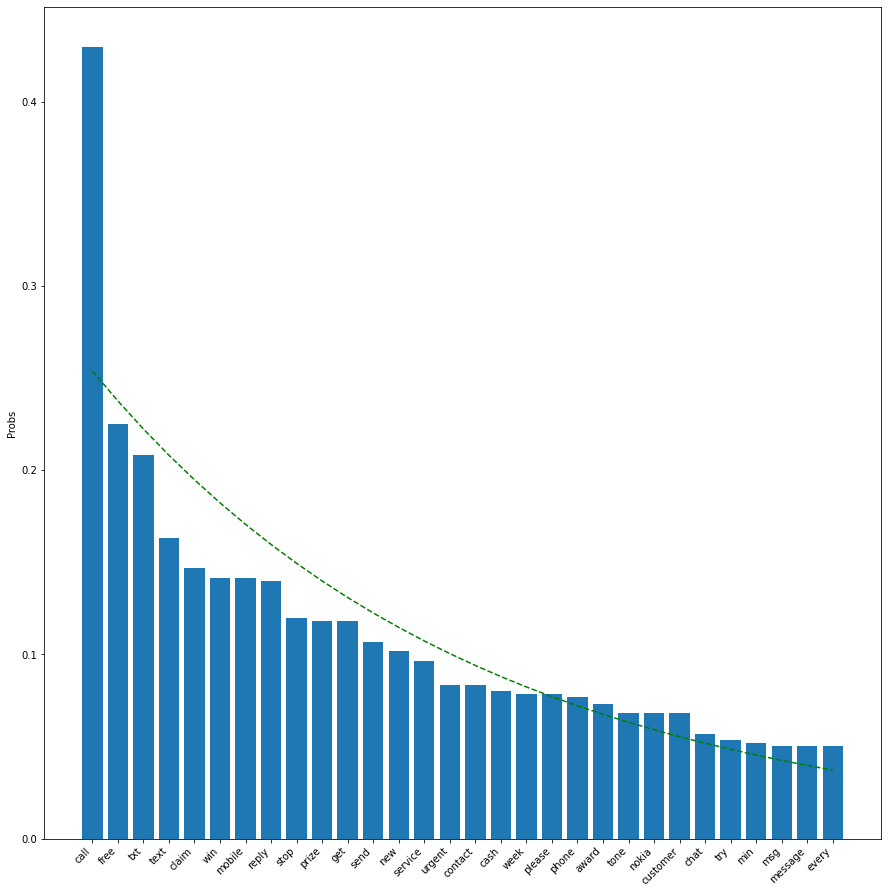

In [32]:
spam_vocab = clf.get_spam_vocab(30)
print(f'{spam_vocab}')

plot_vocab(spam_vocab)

[('get', 0.11230366492146597), ('come', 0.0630890052356021), ('call', 0.05602094240837696), ('know', 0.05130890052356021), ('like', 0.04869109947643979), ('good', 0.048167539267015703), ('time', 0.043455497382198956), ('want', 0.042408376963350786), ('day', 0.039790575916230364), ('love', 0.03848167539267016), ('send', 0.03691099476439791), ('tell', 0.0356020942408377), ('think', 0.03507853403141361), ('take', 0.03507853403141361), ('need', 0.033769633507853405), ('home', 0.032984293193717276), ('see', 0.032722513089005235), ('one', 0.032722513089005235), ('sorry', 0.031675392670157065), ('still', 0.031151832460732984), ('make', 0.030104712041884817), ('today', 0.02801047120418848), ('well', 0.02643979057591623), ('dont', 0.025130890052356022), ('back', 0.025130890052356022), ('work', 0.024607329842931937), ('ask', 0.02382198952879581), ('much', 0.02225130890052356), ('hope', 0.02225130890052356), ('give', 0.02198952879581152)]


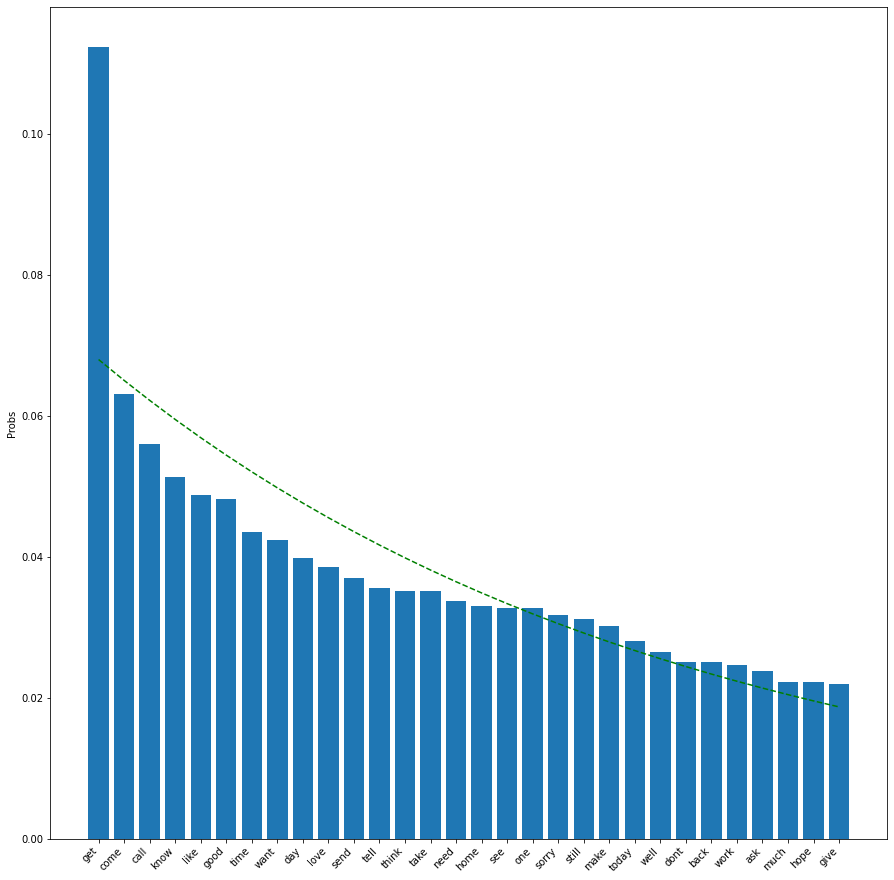

In [33]:
ham_vocab = clf.get_ham_vocab(30)
print(f'{ham_vocab}')

plot_vocab(ham_vocab)

In [34]:
acc = 0.0
for sentence, label in dataset_train:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_train)}')

Accuracy = 0.9338917817523206


In [35]:
acc = 0.0
for sentence, label in dataset_test:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_test)}')

Accuracy = 0.9266968325791856
